TU Delft internship of Bordeaux ENSEIRB -MATMECA student Anouchka Desmettre 
Dates: June 10st - August 31st, 2024 

Supervision: D. Lahaye (DIAM - EEMCS Faculty - TU Delft)

# Title: Mathematical modelling and numerical simulation of driving buses and vibrations door   

We begin our exploration by understanding the diffusion equation, starting in one dimension, where we apply finite differences and solve using basic linear algebra techniques. Progressing to two dimensions, we tackle $\nabla^2 U = 0$, enhancing our approach with 2D grid discretization and comprehensive boundary condition implementations. This prepares us for the complex 2D biharmonic equation, $\nabla^2(EI \nabla^2 U) = S$, where higher order discretization methods and nested system solutions are utilized. Each step builds on the previous, gradually increasing our ability to handle more complex PDEs.

In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Printf

### 1. Diffusion Equation in 1D

The diffusion equation is fundamental in modeling the dispersion of heat, particles, or other quantities in a medium. The instationary or time-dependent form of the diffusion equation is given by :
$$ \frac{\partial T}{\partial t} = D \nabla^2 T + S(x, t) $$
where $T$ represents the diffusing property (like temperature), $D$ is the diffusion coefficient, and $S(x, t)$ is a source term that can vary with time and space.

For our study, we focus on the stationary form of the diffusion equation, where the time-dependent term is absent. We use a Gaussian function for the source term $S$. This function will have a maximum value $A$ representing the magnitude of the force, a width parameter $\sigma$, and be centered at position $x_0$ :

$$ \frac{\partial^2 T}{\partial x^2} = A \exp \left( -\frac{(x - x_0)^2}{2\sigma^2} \right) $$

#### 1.1. Domain Discretization

Suppose the domain is divided into $N$ segments with $N+1$ points ranging from $x_1$ to $x_{N+1}$. 

We decide to space the nodes uniformly, for a uniform spacing $h$ between points, we have $x_i = x_1 + (i-1)h$.

#### 1.2 Finite Difference Formulation

To approximate the second derivative $\frac{d^2T}{dx^2}$, we use the centered finite difference approximation:
$$ T''_i \approx \frac{T_{i-1} - 2T_i + T_{i+1}}{h^2} $$
where $T_i$ is the value of $T$ at point $x_i$.

#### 1.3. Assembly of System Matrix

Setting up equations for each interior point $i = 2, 3, \ldots, N$ results in a system of equations :
- For $i = 2$: $\frac{T_1 - 2T_2 + T_3}{h^2} = 0$
- For $i = 3$: $\frac{T_2 - 2T_3 + T_4}{h^2} = 0$
- ...
- For $i = N$: $\frac{T_{N-1} - 2T_N + T_{N+1}}{h^2} = 0$

We assume that the boundary conditions are specified at points $x_1$ and $x_{N+1}$. For example, if the boundary conditions are of Dirichlet type:
- $T_1 = T_a$
- $T_{N+1} = T_b$

This can be expressed in matrix form $AX = S$, where $A$ is a tridiagonal and its dimensions are : $(N+1 \times N+1 )$ : 
$$
A = \frac{1}{h^2}
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & \ddots & \vdots \\
0 & 1 & -2 & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & 1 \\
0 & \cdots & 0 & 0 & 1
\end{bmatrix}
$$

The source vector $S$ incorporates the distributed force or other effects :
$$
S = \begin{bmatrix}
T_a*h² \\ S(x_2) \\ \vdots \\ S(x_{N}) \\ T_b*h²
\end{bmatrix}
$$
Here, each entry S(x) corresponds to the source term evaluated at the grid points, which might be a function of position such as $A \exp \left( -\frac{(x_i - x_0)^2}{2\sigma^2} \right)$.

#### 1.4. Solving the Linear System

Since matrix $A$ is tridiagonal and symmetric, efficient methods exist for solving this system, such as LU decomposition.

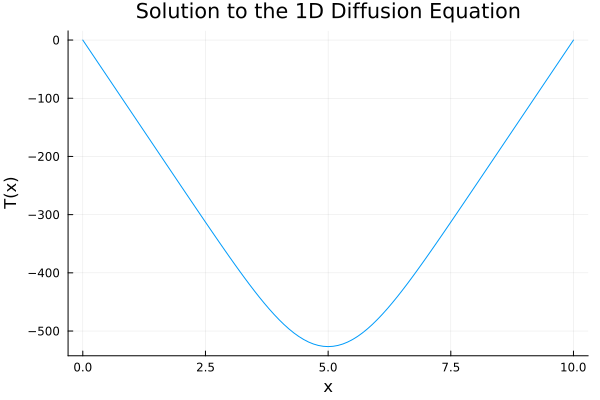

In [17]:
using SparseArrays  # Important pour utiliser les matrices creuses

# Mesh parameters
N = 100             # Number of interior points
L = 10.0            # Length of the domain
h = L / N           # Mesh spacing

# Grid point positions
x = range(0, L, length=N+1)

# Boundary conditions
T_a = 0.0
T_b = 0.0

# Construct the sparse matrix A using Tridiagonal
A = Tridiagonal(1/h^2 * ones(N), -2/h^2 * ones(N+1), 1/h^2 * ones(N))

# Apply boundary conditions directly
A[1, 1] = 1.0
A[N+1, N+1] = 1.0
A[1, 2] = 0.0
A[N+1, N] = 0.0

# Construct the source vector S
x0 = L / 2       # Center of the Gaussian impulse
sigma = L / 10   # Standard deviation of the Gaussian
Amp = 100        # Amplitude of the impulse
S = Amp * exp.(-0.5 * ((x .- x0) / sigma).^2)
S[1] = T_a 
S[N+1] = T_b 

# LU decomposition (sparse matrix)
lu_decomp = lu(A)

# Solving the system using the LU factors
T = lu_decomp \ S

# Visualization of the solution
using Plots
plot(x, T, title="Solution to the 1D Diffusion Equation", xlabel="x", ylabel="T(x)", legend=false)


### 2. Diffusion Equation in 2D

Having successfully solved the 1D diffusion equation where the source term was modeled as a Gaussian function, we are now ready to extend our approach to a more complex 2D scenario. The 2D diffusion equation can model phenomena such as heat distribution in a rectangular plate where both spatial dimensions have an impact. The equation is represented as follows:

$$
\nabla^2 T = S(x,y)
$$

To solve this equation over a 2D domain, we will leverage the Kronecker Product Approach. This approach builds upon our 1D solution by applying it separately along each spatial dimension and then combining the results to cover the entire 2D domain. This method not only simplifies the construction of our system matrix but also efficiently encapsulates the effects of diffusion in both directions.

First we will wolve the equation for : $S(x,y) = 0$. 
We assume that the boundary conditions are specified at the edges of the rectangular domain, each side representing a different boundary condition. Here’s how the conditions are applied : 
- $T_{i, N_y+1} = T_{north}$
- $T_{i,1} = T_{south}$
- $T_{1,j}      = T_{west}$
- $T_{N_x+1, j} = T_{east}$


#### 2.1. Matrix Construction

 - The matrix $A_{xx}$ applies the 1D diffusion operation along the x-direction for each fixed y-coordinate:
$$
A_{xx} = A_{1Dx} \otimes I_{N_y + 1}
$$

Here, $A_{1D}$ is our tridiagonal matrix from the 1D case, and $I_{N_y + 1}$ is the identity matrix of size $(N_y + 1) \times (N_y + 1)$. This results in a block diagonal matrix where each block corresponds to a row of grid points in the y-direction.

- Similarly, $A_{yy}$ handles diffusion along the y-direction for each fixed x-coordinate:
$$
A_{yy} = I_{N_x + 1} \otimes A_{1Dy}
$$

This configuration also results in a block diagonal matrix, but each block corresponds to a column of grid points in the x-direction.

- The combined system matrix $A$ for the 2D scenario, which effectively models diffusion in both dimensions, is the sum of the two matrices:
$$
A = A_{xx} + A_{yy}
$$



In [2]:
# Parameters
Nx = 10
Ny = 10
h  = 1.0 / Nx  # Assuming equal spacing for simplicity
hx = h 
hy = h; 

In [3]:
# Create the 1D diffusion matrix without any boundary conditions
function create_1D_diffusion_matrix(N, h)
    A_1D = spzeros(N+1, N+1)
    for i in 2:N
        A_1D[i, i-1] = 1 / h^2
        A_1D[i, i] = -2 / h^2
        A_1D[i, i+1] = 1 / h^2
    end
    return A_1D
end

# Create A_1D for both dimensions
A_1Dx = create_1D_diffusion_matrix(Nx, h)
A_1Dy = create_1D_diffusion_matrix(Ny, h)

# Create Axx and Ayy using Kronecker products
Axx = kron(A_1Dx, sparse(I, Ny+1, Ny+1))
Ayy = kron(sparse(I, Nx+1, Nx+1), A_1Dy)

# Combine Axx and Ayy to form the full 2D diffusion matrix A
A = Axx + Ayy

# Display the matrix A
println("Matrix A_1Dy:")
display(A_1Dy)
println("Matrix Axx:")
display(Axx)
println("Matrix A:yy")
display(Ayy)
println("Matrix A without boundary conditions:")
display(A)


Matrix A_1Dy:


11×11 SparseMatrixCSC{Float64, Int64} with 27 stored entries:
    ⋅       ⋅       ⋅       ⋅       ⋅   …      ⋅       ⋅       ⋅      ⋅ 
 100.0  -200.0   100.0      ⋅       ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅    100.0  -200.0   100.0      ⋅          ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅    100.0  -200.0   100.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅    100.0  -200.0         ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅    100.0  …      ⋅       ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅       100.0      ⋅       ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅      -200.0   100.0      ⋅      ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅       100.0  -200.0   100.0     ⋅ 
    ⋅       ⋅       ⋅       ⋅       ⋅          ⋅    100.0  -200.0  100.0
    ⋅       ⋅       ⋅       ⋅       ⋅   …      ⋅       ⋅       ⋅      ⋅ 

Matrix Axx:


121×121 SparseMatrixCSC{Float64, Int64} with 297 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⡀⠀⠀⢀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠘⢢⡀⠀⠑⢄⠀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠘⠢⡀⠀⠑⢄⠀⠈⠢⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠢⡀⠀⠑⢄⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠦⡀⠀⠑⢄⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠑⢄⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠑⢄⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠑⢄⠀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠑⢄⠀⠈⠢⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠀⠑⢄⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢢⡀⠀⠑⢄⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠀⠑⢄⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠀⠑⢄⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠀⠑⢄⠀⠈⠲⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠀⠑⢄⠀⠈⠢⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠢⡀⠀⠑⢄⠀⠈⠢⡄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠀⠑⢄⠀⠈⠣⡄⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠁⠀⠀⠈⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

Matrix A:yy


121×121 SparseMatrixCSC{Float64, Int64} with 297 stored entries:
⎡⠲⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⠦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠛⣂⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠡⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠲⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⠦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢂⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠩⣤⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠲⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⠦⎦

Matrix A without boundary conditions:


121×121 SparseMatrixCSC{Float64, Int64} with 513 stored entries:
⎡⠲⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⡀⠈⠻⢦⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠘⢢⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠘⠢⡀⠈⠛⣆⡀⠈⠢⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠢⡀⠈⠻⣦⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠦⡀⠈⠙⣤⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠻⣦⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠱⣤⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠳⣦⡀⠈⠢⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠈⠻⢦⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢢⡀⠈⠻⣦⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠛⢆⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠻⣦⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠛⣄⡀⠈⠲⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠢⡀⠈⠹⣤⡀⠈⠢⡄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠈⠻⣦⡀⠈⠣⡄⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠳⣦⡀⠈⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⠦⎦

In [4]:
# Implement boundary conditions

# Construct the mesh indicator matrix IG
IG = ones(Int, Nx+1, Ny+1)
IG[2:end-1, 2:end-1] .= 0  # Interior points
IGvec = reshape(IG, (Nx+1)*(Ny+1))  # Vectorize

# Linear indices for interior and boundary nodes
L = LinearIndices(IGvec)
interior_indices = findall(x -> x == 0, IGvec)
boundary_indices = findall(x -> x == 1, IGvec)

# Handle Dirichlet boundary conditions in the matrix and the right-hand side vector
A[boundary_indices, :] .= 0.0
A[boundary_indices, boundary_indices] .= I(length(boundary_indices))

println("Final matrix A:")
display(A)

Final matrix A:


121×121 SparseMatrixCSC{Float64, Int64} with 517 stored entries:
⎡⠳⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⡀⠈⠻⢦⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠘⢢⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠘⠢⡀⠈⠛⣆⡀⠈⠢⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠢⡀⠈⠻⣦⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠦⡀⠈⠙⣤⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠻⣦⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠱⣤⡀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⡀⠀⠳⣦⡀⠈⠢⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠈⠻⢦⠀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢢⡀⠈⠻⣦⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠛⢆⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠻⣦⡀⠈⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠛⣄⡀⠈⠲⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢢⡀⠈⠻⣦⡀⠈⠢⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠢⡀⠈⠹⣤⡀⠈⠢⡄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠈⠻⣦⡀⠈⠣⡄⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠳⣦⡀⠈⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢦⎦

#### 2.2. Solving the System

In [5]:
# Define the boundary conditions
T_north = 100.0   # Example temperature for the north boundary
T_south = 50.0    # Example temperature for the south boundary
T_west  = 75.0    # Example temperature for the west boundary
T_east  = 25.0    # Example temperature for the east boundary

# Create the right-hand side vector
S = zeros(Nx+1, Ny+1)  

# North and South boundaries 
for i in 1:Nx+1
    S[i, Ny+1] = T_north
    S[i, 1] = T_south
end

# West and East boundaries
for j in 1:Ny+1
    S[1, j] = T_west
    S[Nx+1, j] = T_east
end

# Reshape F into a vector
s = reshape(S, (Nx+1)*(Ny+1))

# Handle Dirichlet boundary conditions in the matrix and the right-hand side vector
s[boundary_indices] .= S[boundary_indices]

println("Right-hand side vector f:")
display(s)

Right-hand side vector f:


121-element Vector{Float64}:
  75.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  25.0
  75.0
   0.0
   ⋮
  25.0
  75.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
 100.0
  25.0

2. **Solve the Linear System $AX = S$** : The solution vector $X$, which represents the flattened matrix of temperature or concentration values, is obtained by solving this system.


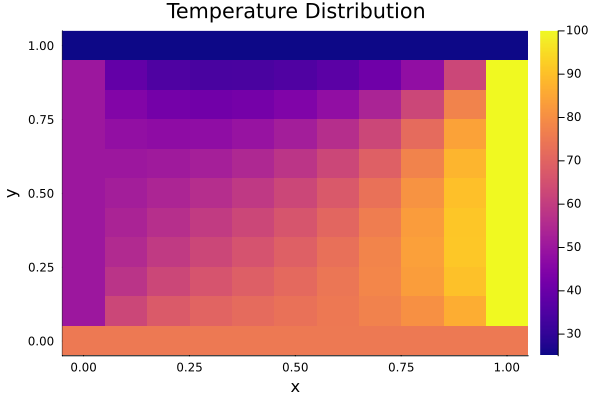

In [6]:
# Solve the linear system
u = A \ s

# Reshape the solution vector into a 2D array for plotting
U = reshape(u, Nx+1, Ny+1)

# Manually create the mesh grid using broadcasting
x = 0:h:Nx*h
y = 0:h:Ny*h
x_grid = repeat(x', Ny+1, 1)
y_grid = repeat(y, 1, Nx+1)

# Create a 2D heatmap plot
p2d = heatmap(x, y, U, 
              title  = "Temperature Distribution",
              xlabel = "x",
              ylabel = "y",
              color  = :plasma)  # Choose a colormap

savefig(p2d, "temperature_distribution_2D.png")

# Display the 2D plot
display(p2d)

#### 2.3. Diffusion Equation with a Gaussian pulse

We decided to solve the same equation but with a source term : 

$$
\nabla^2 T = A \exp \left( -\frac{(x - x_0)^2 + (y - y_0)^2 }{2\sigma^2} \right)
$$

Here, $T$ represents the temperature at any given point $(x, y)$ on the plate, and the right-hand side is a Gaussian source centered at $(x_0, y_0)$ with spread $\sigma$. This setup allows us to see how a localized heat source affects the temperature distribution across the domain.

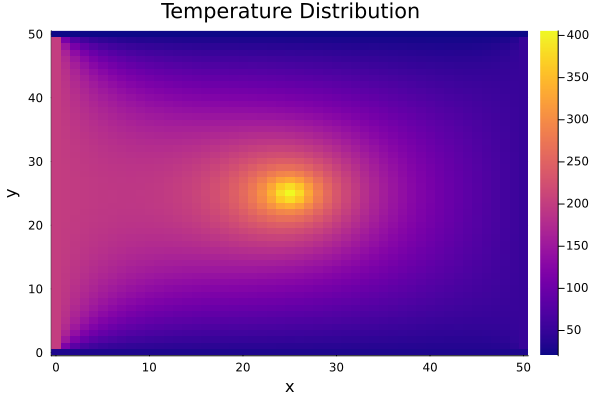

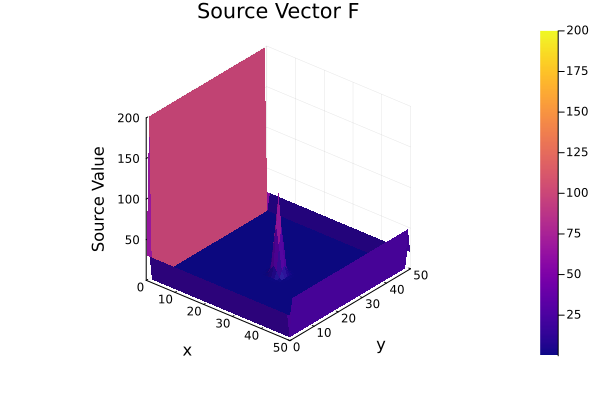

In [37]:
# Grid size
Nx = 50
Ny = 50
h = 1.0

# Define the boundary conditions
T_north = 50.0  # Example temperature for the north boundary
T_south = 200.0  # Example temperature for the south boundary
T_west  = 30.0  # Example temperature for the west boundary
T_east  = 20.0  # Example temperature for the east boundary

# Create the 1D diffusion matrix without boundary conditions
function create_1D_diffusion_matrix(N, h)
    A_1D = spzeros(N+1, N+1)
    for i in 2:N
        A_1D[i, i-1] = 1 / h^2
        A_1D[i, i] = -2 / h^2
        A_1D[i, i+1] = 1 / h^2
    end
    return A_1D
end

# Create A_1D for both dimensions
A_1Dx = create_1D_diffusion_matrix(Nx, h)
A_1Dy = create_1D_diffusion_matrix(Ny, h)

# Create Axx and Ayy using Kronecker products
Axx = kron(A_1Dx, sparse(I, Ny+1, Ny+1))
Ayy = kron(sparse(I, Nx+1, Nx+1), A_1Dy)

# Combine Axx and Ayy to form the full 2D diffusion matrix A
A = Axx + Ayy

# Initialize the source vector F
F = zeros(Nx+1, Ny+1)  # Zero matrix initially

# Parameters for the Gaussian pulse
x0, y0 = 0.5 * Nx, 0.5 * Ny  # Center of the Gaussian
Amp    = 100  # Amplitude of the Gaussian
σ      = 1.0  # Spread of the Gaussian

# Use broadcasting to fill the source vector F with the Gaussian function
x  = (0:Nx) * h
y  = (0:Ny) * h
F .= Amp .* exp.(-((x .- x0).^2 .+ (y' .- y0).^2) ./ (2 * σ^2))

# Apply boundary conditions for the north and south
F[:, Ny+1] .= T_north
F[:, 1] .= T_south

# Apply boundary conditions for the west and east
F[1, :] .= T_west
F[Nx+1, :] .= T_east

# Reshape F into a vector
f = reshape(-F, (Nx+1)*(Ny+1))

# Handle Dirichlet boundary conditions in the matrix and the right-hand side vector
IG = ones(Int, Nx+1, Ny+1)
IG[2:end-1, 2:end-1] .= 0  # Interior points
IGvec = reshape(IG, (Nx+1)*(Ny+1))  # Vectorize

boundary_indices = findall(x -> x == 1, IGvec)

A[boundary_indices, :] .= 0.0
A[boundary_indices, boundary_indices] .= I(length(boundary_indices))
f[boundary_indices] .= F[boundary_indices]

# Solve the linear system
u = A \ f

# Reshape the solution vector into a 2D array for plotting
U = reshape(u, Nx+1, Ny+1)

# Manually create the mesh grid using broadcasting
x_grid = repeat(x', Ny+1, 1)
y_grid = repeat(y, 1, Nx+1)

# Create a 2D heatmap plot for the temperature distribution
p2d = heatmap(x, y, U, 
              title  = "Temperature Distribution",
              xlabel = "x",
              ylabel = "y",
              color  = :plasma)  # Choose a colormap

savefig(p2d, "temperature_distribution_2D.png")

# Display the 2D plot
display(p2d)

# Reshape the source vector F for 3D plotting
F_2D = reshape(F, Nx+1, Ny+1)

# Create a 3D surface plot for the source vector F
p1 = surface(x_grid, y_grid, F_2D, 
             title  = "Source Vector F",
             xlabel = "x",
             ylabel = "y",
             zlabel = "Source Value",
             color  = :plasma,  # Choose a colormap
             camera = (40, 30)) # Adjust the camera angle for better viewing

savefig(p1, "source_vector_F_3D.png")

# Display the 3D plot
display(p1)


The temperature distribution is expected to show a smooth gradient from the center of the grid, where the Gaussian pulse creates a hot spot, towards the edges, where the boundary conditions dictate the temperature values. We can see, for example, on the left-hand side of the plot hotter temperatures due to the boundary $T_{\text{south}} = 200$.

### 3. Time-Dependent Diffusion Equation in 2D 

To explore how the temperature evolves over time, we will introduce time dependence into the diffusion equation. The time-dependent diffusion equation can be written as:

$$ \frac{\partial T (x, y, t)}{\partial t} = D \nabla^2 T(x, y, t) + S(x,y) $$


Where $D$ is the diffusion coefficient and S(x,y) is 0.

In [4]:
# Parameters
Nx         = 20
Ny         = 20
h          = 1.0 / Nx  # Assuming equal spacing for simplicity
hx         = h 
hy         = h; 
D          = 1.0   # Diffusion coefficient, adjust as needed
delta_t    = 0.01  # Time step size
num_steps  = 100;  # Number of time steps

#### 3.1 Time Discretization Strategy

We will leverage the spatial discretization matrices $A_{xx}$ and $A_{yy}$ that we previously constructed. These matrices, derived from the finite difference method, approximate the Laplacian operator $\nabla^2$ in the x and y directions respectively. The combined matrix $A$ defined as $A = A_{xx} + A_{yy}$ will be used to model the spatial components of the diffusion.

For time discretization, we will employ the Backward Euler method, an implicit scheme, due to its stability characteristics, especially suitable for diffusion processes. The numerical scheme updates the temperature field $ T $ by solving the linear system :

$$
\frac{T^{n+1} - T^n}{\Delta t} = D A T^{n+1} + S \iff
T^{n+1} - \Delta t (D A T^{n+1} + S) = T^n
$$

This can be simplified to:

$$
(I - \Delta t D A) T^{n+1} = T^n + \Delta t S
$$

where:
- $ I $ is the identity matrix of appropriate size.
- $ \Delta t $ is the time step.
- $ T^n $ is the vector of temperatures at the current time step.

#### 3.2 Implementation Steps


1. **Precompute the System Matrix and Initialization**:
   - Compute $I - \Delta t D A$ only once before the loop to save computation time during each iteration. This matrix remains constant across all time steps.
   - Start with an initial temperature distribution. Here, it's initialized to zero, but you can modify this depending on your initial conditions.

In [5]:
# Matrix A (same code as before)

# Create the 1D diffusion matrix without any boundary conditions
function create_1D_diffusion_matrix(N, h)
    A_1D = spzeros(N+1, N+1)
    for i in 2:N
        A_1D[i, i-1] = 1 / h^2
        A_1D[i, i] = -2 / h^2
        A_1D[i, i+1] = 1 / h^2
    end
    return A_1D
end

# Create A_1D for both dimensions
A_1Dx = create_1D_diffusion_matrix(Nx, h)
A_1Dy = create_1D_diffusion_matrix(Ny, h)

# Create Axx and Ayy using Kronecker products
Axx = kron(A_1Dx, sparse(I, Ny+1, Ny+1))
Ayy = kron(sparse(I, Nx+1, Nx+1), A_1Dy)

# Combine Axx and Ayy to form the full 2D diffusion matrix A
A = Axx + Ayy

# ----------------------------------------------------------------------------------------------------
#Implement boundary conditions

# Construct the mesh indicator matrix IG
IG = ones(Int, Nx+1, Ny+1)
IG[2:end-1, 2:end-1] .= 0  # Interior points
IGvec = reshape(IG, (Nx+1)*(Ny+1))  # Vectorize

# Linear indices for interior and boundary nodes
L = LinearIndices(IGvec)
interior_indices = findall(x -> x == 0, IGvec)
boundary_indices = findall(x -> x == 1, IGvec)

# Handle Dirichlet boundary conditions in the matrix and the right-hand side vector
A[boundary_indices, :] .= 0.0
A[boundary_indices, boundary_indices] .= I(length(boundary_indices))

println("This is the A matrix") 
display(A)

# ----------------------------------------------------------------------------------------------------
# Create an identity matrix as a sparse matrix
I_matrix = Matrix{Float64}(I, size(A))

# Multiply each element of A by delta_t * D
scaled_A = delta_t * D * A

# Compute the system matrix: I - delta_t * D * A
system_matrix = I_matrix - scaled_A

# Display the system matrix
println("System Matrix I - delta_t*D*A :")
display(system_matrix)

# ----------------------------------------------------------------------------------------------------
# Initial condition: assume T is initially zero
T = zeros((Nx+1) * (Ny+1))  # Correctly calculate the size for the flattened vector

println("Initial Temperature T_0 :")
display(T) 


This is the A matrix


441×441 SparseMatrixCSC{Float64, Int64} with 2037 stored entries:
⎡⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠙⢦⡻⣦⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠙⢦⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢮⡻⢮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⢎⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣎⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡛⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣬⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡹⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡱⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡳⣮⡳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⠳⣄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠻⣮⠳⣄⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

System Matrix I - delta_t*D*A :


441×441 Matrix{Float64}:
 0.99  0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.99  0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.99  0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.99  0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.99  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.99  …  0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0   …  0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
 ⋮           

Initial Temperature T_0 :


441-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

2. **Time-stepping Loop**:
      - **Right-Hand Side Calculation**: At each time step, compute the right-hand side $T^n + \Delta t S$, which combines the previous temperature distribution with the source term contribution scaled by the time step.
    - **Solve the Linear System**: Use the precomputed system matrix to solve for $T^{n+1}$. This involves a matrix inversion or decomposition, which is efficiently handled by Julia's backslash operator.
    - **Visualization/Logging**: Optionally, monitor or visualize the temperature distribution at certain intervals to check the evolution or debug the process.


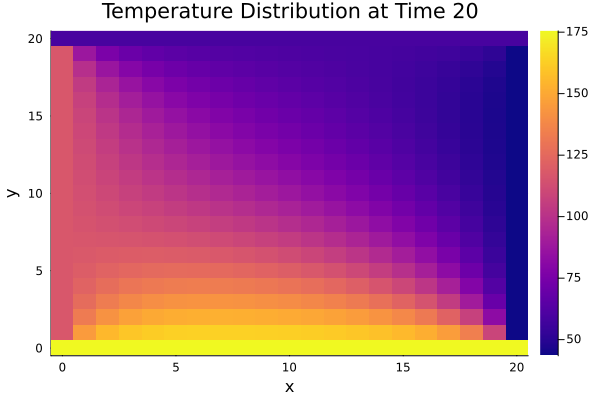

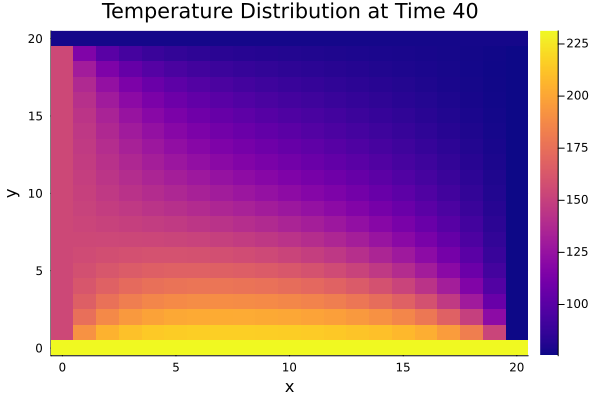

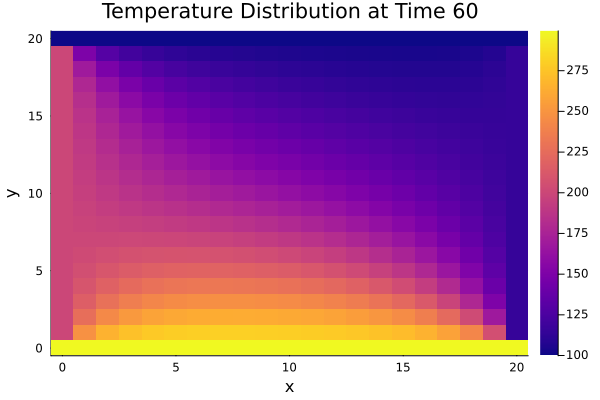

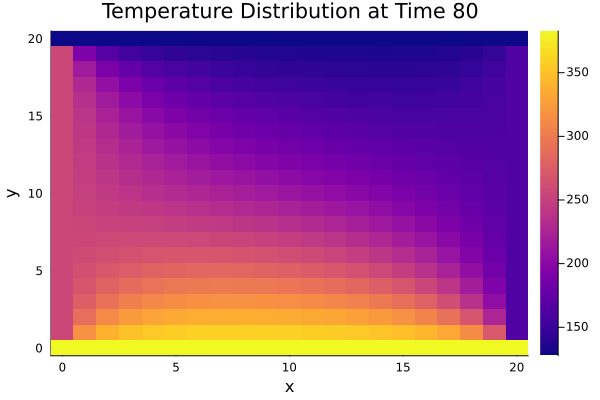

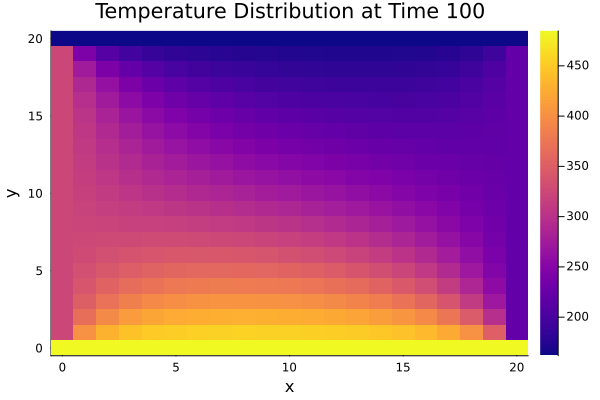

In [13]:
# Create the 2D grid of points
x    = range(0, stop=Nx, length=Nx+1)
y    = range(0, stop=Ny, length=Ny+1)
X, Y = [i for i in x, j in y]

# Define the Gaussian pulse function in 2D
function f(x, y, p)
    Amp, x0, y0, sigma = p
    return Amp * exp(-((x - x0)^2 + (y - y0)^2) / sigma^2)
end

# Define the parameters for the Gaussian pulse
Amp    = 1.0
x0, y0 = Nx/2, Ny/2  # Center the pulse in the middle of the grid
sigma  = 1.0

p = [Amp, x0, y0, sigma]

# Apply the Gaussian pulse function using broadcasting
S .= S .+ f.(X, Y, Ref(p))

# --------------------------------------------------------------------
# Define boundary conditions
T_north = 100.0   # Temperature for the north boundary
T_south = 50.0    # Temperature for the south boundary
T_west  = 75.0    # Temperature for the west boundary
T_east  = 25.0    # Temperature for the east boundary

# Create the right-hand side vector
S = zeros(Nx+1, Ny+1)  

# Apply boundary conditions using element-wise assignment
S[:, Ny+1] .= T_north  # North boundary
S[:, 1] .= T_south     # South boundary
S[1, :] .= T_west      # West boundary
S[Nx+1, :] .= T_east   # East boundary

# Apply the excitation (Gaussian pulse) to the right-hand side vector
S .= S .+ f.(X, Y, Ref(p))  # Adding the Gaussian pulse to the excitation

# Reshape S into a vector
s = reshape(S, (Nx+1)*(Ny+1))

# Apply Dirichlet boundary conditions in the matrix and the right-hand side vector
s[boundary_indices] .= S[boundary_indices]

# --------------------------------------------------------------------
# Pre-allocate the space for storing the results
T_steps = zeros(Float64, (Nx+1)*(Ny+1), num_steps + 1)
T_steps[:, 1] .= T  # Initialize with the initial condition

# Time-stepping loop
for step in 1:num_steps
    rhs = T + delta_t * s
    T = system_matrix \ rhs
    T_steps[:, step + 1] .= T  # Store the solution at this step

    if step % 20 == 0
        T_2D = reshape(T, Nx+1, Ny+1)
        using Plots
        gr()  # Use the GR backend for plotting

        p = heatmap(0:Nx, 0:Ny, T_2D,
                    title = "Temperature Distribution at Time $step",
                    xlabel = "x",
                    ylabel = "y",
                    color = :plasma)
        
        display(p)
    end
end


#### 3.3 Time-Dependent Diffusion Equation with a Gaussian pulse

As before, we decided to solve the same equation but with a source term : 

$$
S(x_i,y_i) = A \exp \left( -\frac{(x_i - x_0)^2 + (y_i - y_0)^2 }{2\sigma^2} \right)
$$

Here, $T$ represents the temperature at any given point $(x, y)$ on the plate, and the right-hand side is a Gaussian source centered at $(x_0, y_0)$ with spread $\sigma$. This setup allows us to see how a localized heat source affects the temperature distribution across the domain.

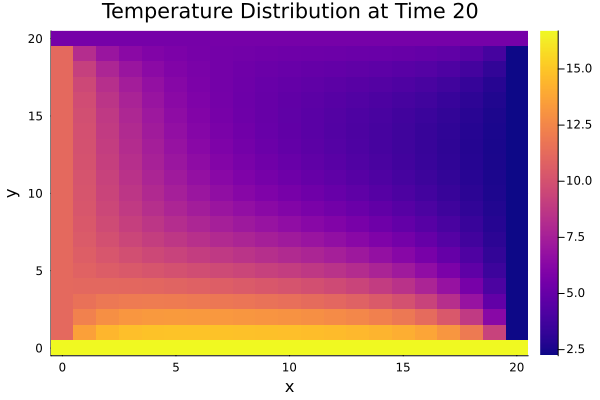

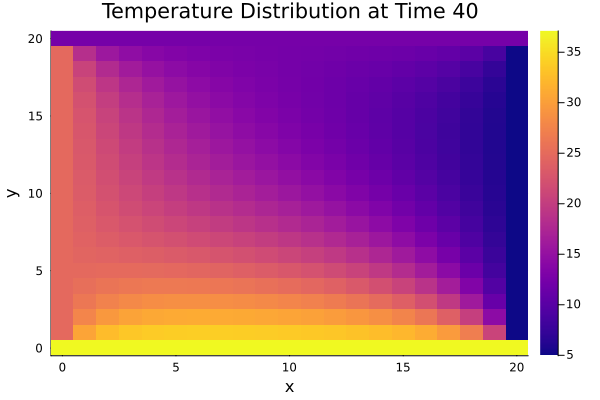

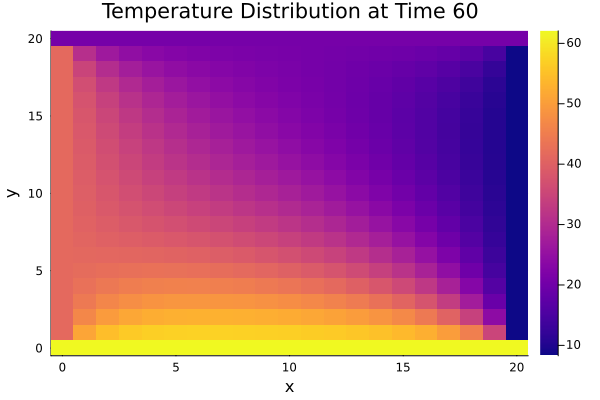

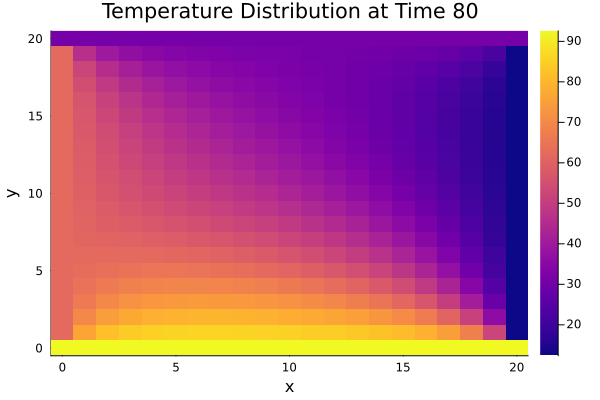

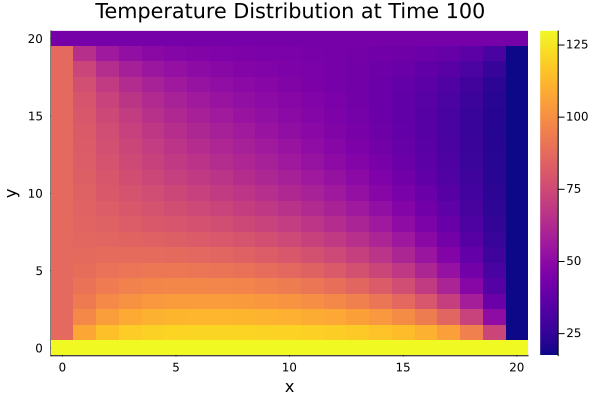

Final Temperature Distribution:


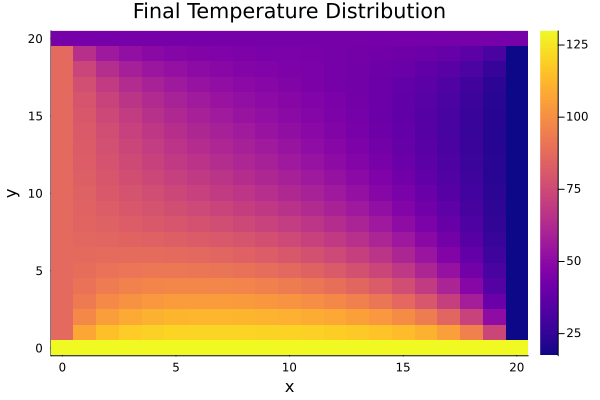

In [12]:
# Matrix A (same code as before)

# Create the 1D diffusion matrix without any boundary conditions
function create_1D_diffusion_matrix(N, h)
    A_1D = spzeros(N+1, N+1)
    for i in 2:N
        A_1D[i, i-1] = 1 / h^2
        A_1D[i, i] = -2 / h^2
        A_1D[i, i+1] = 1 / h^2
    end
    return A_1D
end

# Create A_1D for both dimensions
A_1Dx = create_1D_diffusion_matrix(Nx, h)
A_1Dy = create_1D_diffusion_matrix(Ny, h)

# Create Axx and Ayy using Kronecker products
Axx = kron(A_1Dx, sparse(I, Ny+1, Ny+1))
Ayy = kron(sparse(I, Nx+1, Nx+1), A_1Dy)

# Combine Axx and Ayy to form the full 2D diffusion matrix A
A = Axx + Ayy

# ----------------------------------------------------------------------------------------------------
#Implement boundary conditions

# Construct the mesh indicator matrix IG
IG = ones(Int, Nx+1, Ny+1)
IG[2:end-1, 2:end-1] .= 0  # Interior points
IGvec = reshape(IG, (Nx+1)*(Ny+1))  # Vectorize

# Linear indices for interior and boundary nodes
L = LinearIndices(IGvec)
interior_indices = findall(x -> x == 0, IGvec)
boundary_indices = findall(x -> x == 1, IGvec)

# Handle Dirichlet boundary conditions in the matrix and the right-hand side vector
A[boundary_indices, :] .= 0.0
A[boundary_indices, boundary_indices] .= I(length(boundary_indices))

# ----------------------------------------------------------------------------------------------------
# Create an identity matrix as a sparse matrix
size_identity = (Nx + 1) * (Ny + 1)
identity_matrix_sparse = I(size_identity)

# Multiply each element of A by delta_t * D
scaled_A = delta_t * D * A

# Compute the system matrix: I - delta_t * D * A
system_matrix = identity_matrix_sparse - scaled_A

# ----------------------------------------------------------------------------------------------------
# Initial condition: assume T is initially zero
T = zeros((Nx+1) * (Ny+1))  # Correctly calculate the size for the flattened vector

# ----------------------------------------------------------------------------------------------------
# Vector S (same code as before) 
# Define the boundary conditions
T_north = 10.0   # Temperature for the north boundary
T_south = 50.0    # Temperature for the south boundary
T_west  = 75.0    # Temperature for the west boundary
T_east  = 25.0    # Temperature for the east boundary

# Create the right-hand side vector
S = zeros(Nx+1, Ny+1)  

# Parameters for the Gaussian pulse
x0, y0 = 0.5 * Nx, 0.5 * Ny  # Center of the Gaussian
Amp    = 100000000  # Amplitude of the Gaussian
σ      = 1.0  # Spread of the Gaussian

# Use broadcasting to fill the source vector F with the Gaussian function
x  = (0:Nx) * h
y  = (0:Ny) * h
S .= Amp .* exp.(-((x .- x0).^2 .+ (y' .- y0).^2) ./ (2 * σ^2))

# Apply boundary conditions for the north and south
S[:, Ny+1] .= T_north
S[:, 1]    .= T_south

# Apply boundary conditions for the west and east
S[1, :]    .= T_west
S[Nx+1, :] .= T_east

# Reshape F into a vector
s = reshape(-S, (Nx+1)*(Ny+1))

# Apply Dirichlet boundary conditions in the matrix and the right-hand side vector
s[boundary_indices] .= S[boundary_indices]

# ----------------------------------------------------------------------------------------------------
# Create a vector to store temperature results at each timestep
T_steps = Vector{Vector{Float64}}(undef, num_steps + 1)
T_steps[1] = T  # Initialize with the initial condition

# Time-stepping loop
for step in 1:num_steps
    # Compute the right-hand side of the equation
    rhs = T + delta_t * s
    
    # Solve the linear system to get T^{n+1}
    T = system_matrix \ rhs
    
    # Store the result for later visualization or analysis
    T_steps[step + 1] = T
    
    # Display results every 10 timesteps
    if step % 20 == 0
        # Reshape for display
        T_2D = reshape(T, Nx+1, Ny+1)
        
        # Create the 2D plot
        using Plots
        gr()  # Use the GR backend for plotting
        
        p = heatmap(0:Nx, 0:Ny, T_2D,
                    title = "Temperature Distribution at Time $step",
                    xlabel = "x",
                    ylabel = "y",
                    color = :plasma)
        
        # Display the plot
        display(p)
    end
end

# Display the final temperature after the last timestep
println("Final Temperature Distribution:")
T_final = reshape(T, Nx+1, Ny+1)
p_final = heatmap(0:Nx, 0:Ny, T_final,
                   title = "Final Temperature Distribution",
                   xlabel = "x",
                   ylabel = "y",
                   color = :plasma)

display(p_final)

### 4. Stationnary Biharmonic Equation in 2D 

The stationnary biharmonic equation is a fourth-order partial differential equation given by :

$$
\nabla^2 (EI(x,y) \times \nabla^2 u(x,y)) = S(x,y)
$$

where:
- $u(x,y)$ is the unknown function we want to solve for, typically representing a displacement field.
- $EI(x,y)$ is the flexural rigidity.
- $S(x,y)$ is the source term representing external forces or loads.

Here, we can leverage the finite difference method and the diffusion matrices we previously constructed for solving the Laplace equation. By representing the Laplace operator using sparse matrices, we can efficiently solve these coupled equations. We use the same discretized domain. 

In [1]:
# Parameters
Nx         = 2
Ny         = 2
h          = 1.0 / Nx  # Assuming equal spacing for simplicity
hx         = h 
hy         = h; 

#### 4.1 Diffusion Matrices Creation and Biharmonic Equation Reformulation

Previously, we developed matrices $A$ which approximate the Laplace operator $ \nabla^2$ in 2D using finite differences. These matrices help us transform the continuous Laplacian into a discrete form that can be solved numerically.

To solve this biharmonic equation, we can decompose it into two sequential Laplace equations:
   $$
   \nabla^2 v = \frac{S(x,y)}{EI(x,y)}
   $$
   and
   $$
   \nabla^2 u = v
   $$

This decomposition helps simplify the solution process. Instead of solving a single biharmonic equation directly, we solve two simpler Laplace equations one after the other.

We first solve the equation $\nabla^2 v = \frac{S(x,y)}{EI(x,y)}$ to find the intermediate variable $v$.
Once we have $v$, we solve the second equation $\nabla^2 u = v$ to find the final solution $u$.

- **Apply Boundary Conditions**: Define and apply the necessary boundary conditions for both $u$ and $v$.
- **Solve the Linear Systems**: Solve the resulting sparse linear systems to find the solution $u$.
